In [45]:
#House keeping. Make sure to install tensorflow before running this cell. 
from __future__ import print_function

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle

import keras
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Dropout, Activation, LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D



import matplotlib.pyplot as plt

import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [46]:
#Reading in the data:
df = pd.read_csv('/Volumes/Samsung_T5/nameracesample.csv',dtype={'name_last':str,'name_first':str,'fips':str,'zip':str,'race':str,
                                                                 'frac_white':float,'frac_black':float,'frac_asian':float})

In [47]:
#Schema:
df.race.unique()

array(['nh_white', 'hispanic', 'nh_black', 'asian'], dtype=object)

In [54]:
#Define data cleaning precedure:

def data_preprocessing(df,sample,ntest,ngrams,feature_len,model,strat_sampling=False,random_state=21):
    
    #Cleaning:
    df.dropna(subset=['name_first', 'name_last'], inplace=True)
    
    #Capitalize the first letters:
    df['name_first'] = df.name_first.str.title()
    df['name_last'] = df.name_last.str.title()
    
    # Concatenate the data depending on the model:
    
    if model=='fl_fips':
        df['name_last_name_first'] = df['name_last'] + ' ' + df['name_first']+' '+df['fips']
    elif model=='fl_zip':
        df['name_last_name_first'] = df['name_last'] + ' ' + df['name_first']+' '+df['zip']
    elif model=='l':
        df['name_last_name_first'] = df['name_last']
    elif model=='f':
        df['name_last_name_first'] = df['name_first']
    elif model=='fl' or model=='fl_zipcomp':
        df['name_last_name_first'] = df['name_last'] + ' ' + df['name_first']
    else:
        sys.exit('Invalid model name. Should take one of the following values: fl_fips, fl_zip, fl_zipcomp, fl, l')
                
    #Randomly shuffle the data:    
    df=shuffle(df, random_state=random_state)
    
    #Split the data into test, dev and train sets:
    ndev=2*ntest
    
    sdf_test=df[:ntest]
    sdf_dev=df[ntest:ndev]
    sdf_train=df[ndev:]
    
    #Sample train sample:
    if strat_sampling==True:
    
        sample_non_white=sdf_train[sdf_train['race']!="nh_white"].groupby('race', group_keys=False).apply(lambda x: x.sample(min(len(x),sample),random_state=21))
        sample_white=sdf_train[sdf_train['race']=="nh_white"].sample(n=sample, random_state=random_state)

        sdf_train=pd.concat([sample_non_white,sample_white])
    
        sdf_train=shuffle(sdf_train, random_state=random_state)
        
    else:
        sdf_train=sdf_train.sample(n=sample, random_state=random_state)
    
    #Print the breakdown of number of observations by race in the train sample:
    
    print(sdf_train.groupby('race').agg({'name_first': 'count'}))
    
    
    #Concat test, dev and train samples:
    
    sdf=pd.concat([sdf_test,sdf_dev,sdf_train])

    #Build word list:
    word_vect = CountVectorizer(analyzer='word',  max_df=0.3, min_df=3, ngram_range=word_ngrams, lowercase=False) 
    word_a = word_vect.fit_transform(sdf.name_last_name_first)
    word_b = word_vect.inverse_transform(word_a)
    word_vocab = word_vect.vocabulary_
    
    #Build ngram list:
    char_vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=3, ngram_range=ngrams, lowercase=False) 
    char_a = char_vect.fit_transform(sdf.name_last_name_first)
    char_b = char_vect.inverse_transform(char_a)
    char_vocab = char_vect.vocabulary_

    #Number of words in the vocabularies:
    print("Number of words:",len(word_vocab))
    print("Number of characters:",len(word_vocab))

    #Implement one-hot encoding first for words and then for bi-chars:
    X=[]
    for obs in word_b:
        x=[]
        for w in obs:
                x.append(word_vocab[w])
        X.append(x)

    add=len(word_vocab)  
    index=0

    for obs in char_b:
        x=X[index]
        for c in obs:
            x.append(add+char_vocab[c])
        index+=1

    # Check max/avg feature
    X_len = []
    for x in X:
        X_len.append(len(x))

    max_feature_len = max(X_len)
    avg_feature_len = int(np.mean(X_len))

    print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
    y = np.array(sdf.race.astype('category').cat.codes)

    # Split train, dev and test datasets
    
    X_test=X[:ntest]
    y_test=y[:ntest]
    
    X_dev=X[ntest:ndev]
    y_dev=y[ntest:ndev]
    
    X_train=X[ndev:]
    y_train=y[ndev:]

    print(len(X_train), 'train sequences')
    print(len(X_dev), 'dev sequences')
    print(len(X_test), 'test sequences')
    
    #Pad sequences with 0s to make sure that the length is the same:

    print('Pad sequences (samples x time)')
    X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
    X_dev = sequence.pad_sequences(X_dev, maxlen=feature_len)
    X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
    print('X_train shape:', X_train.shape)
    print('X_dev shape:', X_dev.shape)
    print('X_test shape:', X_test.shape)

    num_classes = np.max(y_train) + 1
    print(num_classes, 'classes')

    print('Convert class vector to binary class matrix '
          '(for use with categorical_crossentropy)')
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_dev = keras.utils.to_categorical(y_dev, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    print('y_train shape:', y_train.shape)
    print('y_dev shape:', y_dev.shape)
    print('y_test shape:', y_test.shape)
    print('Number of classes:', y_train.shape[1])
    
    #Getting zipcode composition data for train, test, dev:
    
    if set(["frac_white","frac_black","frac_asian"]).issubset(sdf.columns):
        
        sub=sdf[["frac_white","frac_black","frac_asian"]]
    
        N_test=sub[:ntest]
    
        N_dev=sub[ntest:ndev]
    
        N_train=sub[ndev:]

    return word_vocab, char_vocab, X_train, X_dev, X_test, y_train, y_dev, y_test, N_test, N_dev, N_train

### Define the baseline model that can be used for predicting race using:
- Only first name (f)
- Only last name (l)
- First name and last name (fl)
- First name, last name and zipcode string (flz)

In [86]:
#Baseline LSTM
def build_model_lstm(num_words,num_classes,feature_len,output_length):
    print('Build model...')

    model = Sequential()
    model.add(Embedding(num_words, output_length, input_length=feature_len))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

    print(model.summary())
    
    return model

#Alternative LSTM + Conv Layer (performs a bit worse, but runs much faster)
def build_model_conv_lstm(num_words,num_classes,feature_len,output_length):
    model= Sequential()
    model.add(Embedding(num_words, output_length, input_length=feature_len))
    model.add(Conv1D(activation="relu", padding="same", filters=32, kernel_size=3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    print(model.summary())
    
    return model

### Define the baseline model that can be used for predicting race using:
- First name, last name and numerical features, for example, zipcode composition.

In [87]:
def build_model_lstm_zipcode_composition(num_words,num_classes,feature_len,output_length,num_length):
    nlp_input = Input(shape=(feature_len,)) 
    meta_input = Input(shape=(num_length,))
    emb = Embedding(num_words, output_length, input_length=feature_len)(nlp_input) 
    nlp_out = LSTM(100)(emb) 
    concat = concatenate([nlp_out, meta_input]) 
    classifier = Dense(32, activation='relu')(concat) 
    output = Dense(num_classes, activation='sigmoid')(classifier) 
    model = Model(inputs=[nlp_input , meta_input], outputs=[output])
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    print(model.summary())
    
    return model

### Other helpful evaluation functions:

In [79]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    
def model_evaluate(model,X,y):
    y_pred = model.predict_classes(X, verbose=2)
    
    p = model.predict_proba(X, verbose=2) # to predict probability
    
    target_names = list(df.race.astype('category').cat.categories)
    
    #print("Model's performance:")
    print(classification_report(np.argmax(y, axis=1), y_pred, target_names=target_names))
    print(confusion_matrix(np.argmax(y, axis=1), y_pred))

### First name and Last name prediction

In [102]:
#Parameters:
sample=1000000 #number of observations sampled from the original dataset, could be the length of the entire dataset.
ntest=50000 #number of observations in the test and dev samples
word_ngrams=(1,1) #include separate words
ngrams=(2,2) #Range of n-grams, (2,2) means include only bi-grams.
feature_len=25 #Sequence length:
mymodel='fl'

word_vocab, char_vocab, X_train, X_dev, X_test, y_train, y_dev, y_test, _, _, _=data_preprocessing(df,sample,ntest,ngrams,feature_len,model=mymodel,random_state=21)

num_classes=y_train.shape[1]
num_words=len(word_vocab)+len(char_vocab)

          name_first
race                
asian          73278
hispanic      101488
nh_black       54226
nh_white      771008
Number of words: 57948
Number of characters: 57948
Max feature len = 37, Avg. feature len = 13
1000000 train sequences
50000 dev sequences
50000 test sequences
Pad sequences (samples x time)
X_train shape: (1000000, 25)
X_dev shape: (50000, 25)
X_test shape: (50000, 25)
4 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (1000000, 4)
y_dev shape: (50000, 4)
y_test shape: (50000, 4)
Number of classes: 4


Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 32)            1892608   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 1,946,212
Trainable params: 1,946,212
Non-trainable params: 0
_________________________________________________________________
None


/Users/nkotova/opt/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1000000 samples, validate on 50000 samples
Epoch 1/3
1000000/1000000 [==============================] - 618s 618us/step - loss: 0.4134 - accuracy: 0.8754 - val_loss: 0.3765 - val_accuracy: 0.8848
Epoch 2/3
1000000/1000000 [==============================] - 611s 611us/step - loss: 0.3547 - accuracy: 0.8913 - val_loss: 0.3699 - val_accuracy: 0.8877
Epoch 3/3
1000000/1000000 [==============================] - 616s 616us/step - loss: 0.3383 - accuracy: 0.8948 - val_loss: 0.3701 - val_accuracy: 0.8881
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


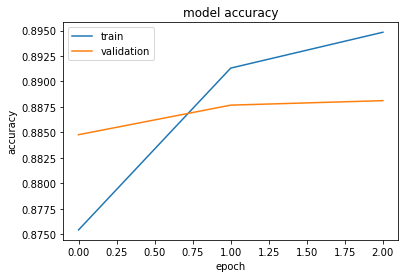

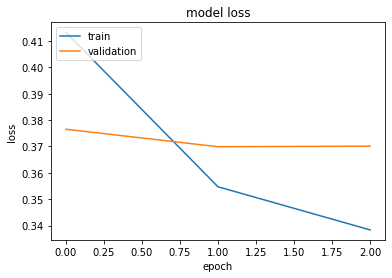

Model's performance:
              precision    recall  f1-score   support

       asian       0.84      0.77      0.80      3637
    hispanic       0.82      0.77      0.80      5207
    nh_black       0.64      0.20      0.30      2714
    nh_white       0.91      0.96      0.93     38442

    accuracy                           0.89     50000
   macro avg       0.80      0.68      0.71     50000
weighted avg       0.88      0.89      0.88     50000

[[ 2807   132    27   671]
 [   48  4006    31  1122]
 [   50    38   537  2089]
 [  453   687   246 37056]]
Model's performance:
              precision    recall  f1-score   support

       asian       0.84      0.77      0.80      3769
    hispanic       0.82      0.76      0.79      5066
    nh_black       0.63      0.20      0.31      2656
    nh_white       0.91      0.96      0.93     38509

    accuracy                           0.89     50000
   macro avg       0.80      0.67      0.71     50000
weighted avg       0.88      0.89 

In [103]:
keras.backend.clear_session()

feature_len=25 #Sequence length
output_length=32 #Length of embedding
batch_size=256
epochs=3
model_ouput_name="model_lstm_fl"

model_lstm = build_model_lstm(num_words,num_classes,feature_len,output_length)

history=model_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
          validation_data=(X_dev, y_dev),verbose=1,shuffle=True)

#Plot accuracy and loss:
plot_loss_accuracy(history)

#Evaluate the model:
model_evaluate(model_lstm,X_dev,y_dev)
model_evaluate(model_lstm,X_test,y_test)

model_lstm.save('/Users/nkotova/Documents/CS 230 Deep Learning/project/models/'+model_ouput_name+".tf")

In [104]:
#predict_classes was depreciated in tf, so below is an alternative way to evaluate the model using model.predict:

y_pred = model_lstm.predict(X_dev, verbose=2)
y_pred=np.argmax(y_pred,axis=1)
target_names = list(df.race.astype('category').cat.categories)
print("Performance on dev set:")
print(classification_report(np.argmax(y_dev,axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_dev, axis=1), y_pred))

y_pred = model_lstm.predict(X_test, verbose=2)
y_pred=np.argmax(y_pred,axis=1)
target_names = list(df.race.astype('category').cat.categories)
print("Performance on test set:")
print(classification_report(np.argmax(y_test,axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

Performance on dev set:
              precision    recall  f1-score   support

       asian       0.84      0.77      0.80      3637
    hispanic       0.82      0.77      0.80      5207
    nh_black       0.64      0.20      0.30      2714
    nh_white       0.91      0.96      0.93     38442

    accuracy                           0.89     50000
   macro avg       0.80      0.68      0.71     50000
weighted avg       0.88      0.89      0.88     50000

[[ 2807   132    27   671]
 [   48  4006    31  1122]
 [   50    38   537  2089]
 [  453   687   246 37056]]
Performance on test set:
              precision    recall  f1-score   support

       asian       0.84      0.77      0.80      3769
    hispanic       0.82      0.76      0.79      5066
    nh_black       0.63      0.20      0.31      2656
    nh_white       0.91      0.96      0.93     38509

    accuracy                           0.89     50000
   macro avg       0.80      0.67      0.71     50000
weighted avg       0.88    

### First name, Last name, and Zip code string prediction

In [105]:
#Parameters:
sample=1000000 #number of observations sampled from the original dataset, could be the length of the entire dataset.
ntest=50000 #number of observations in the test and dev samples
word_ngrams=(1,1) #include separate words
ngrams=(2,2) #Range of n-grams, (2,2) means include only bi-grams.
feature_len=35 #Sequence length
mymodel='fl_zip'

word_vocab, char_vocab, X_train, X_dev, X_test, y_train, y_dev, y_test, _, _, _=data_preprocessing(df,sample,ntest,ngrams,feature_len,model=mymodel,random_state=21)

num_classes=y_train.shape[1]
num_words=len(word_vocab)+len(char_vocab)

          name_first
race                
asian          73278
hispanic      101488
nh_black       54226
nh_white      771008
Number of words: 72935
Number of characters: 72935
Max feature len = 43, Avg. feature len = 20
1000000 train sequences
50000 dev sequences
50000 test sequences
Pad sequences (samples x time)
X_train shape: (1000000, 35)
X_dev shape: (50000, 35)
X_test shape: (50000, 35)
4 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (1000000, 4)
y_dev shape: (50000, 4)
y_test shape: (50000, 4)
Number of classes: 4


Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 32)            2376416   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 2,430,020
Trainable params: 2,430,020
Non-trainable params: 0
_________________________________________________________________
None


/Users/nkotova/opt/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1000000 samples, validate on 50000 samples
Epoch 1/3
1000000/1000000 [==============================] - 854s 854us/step - loss: 0.3700 - accuracy: 0.8864 - val_loss: 0.3304 - val_accuracy: 0.8985
Epoch 2/3
1000000/1000000 [==============================] - 857s 857us/step - loss: 0.3004 - accuracy: 0.9063 - val_loss: 0.3243 - val_accuracy: 0.8988
Epoch 3/3
1000000/1000000 [==============================] - 856s 856us/step - loss: 0.2789 - accuracy: 0.9115 - val_loss: 0.3256 - val_accuracy: 0.8992
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


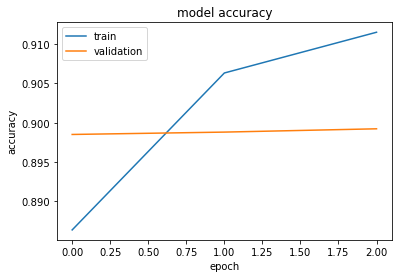

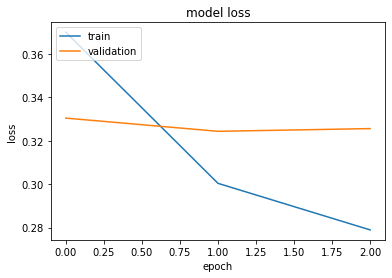

Model's performance:
              precision    recall  f1-score   support

       asian       0.83      0.78      0.81      3637
    hispanic       0.83      0.78      0.80      5207
    nh_black       0.69      0.45      0.54      2714
    nh_white       0.92      0.96      0.94     38442

    accuracy                           0.90     50000
   macro avg       0.82      0.74      0.77     50000
weighted avg       0.89      0.90      0.89     50000

[[ 2834   120    38   645]
 [   47  4075    57  1028]
 [   50    48  1215  1401]
 [  465   684   456 36837]]
Model's performance:
              precision    recall  f1-score   support

       asian       0.84      0.79      0.81      3769
    hispanic       0.82      0.77      0.80      5066
    nh_black       0.71      0.46      0.56      2656
    nh_white       0.93      0.96      0.94     38509

    accuracy                           0.90     50000
   macro avg       0.82      0.75      0.78     50000
weighted avg       0.90      0.90 

In [106]:
keras.backend.clear_session()

output_length=32 #Embedding
batch_size=256
epochs=3
model_name="model_lstm_fl_zip"

model_lstm_fl_zip=build_model_lstm(num_words,num_classes,feature_len,output_length)

history_lstm_fl_zip=model_lstm_fl_zip.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
          validation_data=(X_dev, y_dev),verbose=1,shuffle=True)

plot_loss_accuracy(history_lstm_fl_zip)

model_evaluate(model_lstm_fl_zip,X_dev,y_dev)
model_evaluate(model_lstm_fl_zip,X_test,y_test)

model_lstm_fl_zip.save('/Users/nkotova/Documents/CS 230 Deep Learning/project/models/'+model_name+'.tf')

In [97]:
#predict_classes was depreciated in tf, so below is an alternative way to evaluate the model using model.predict:

y_pred = model_lstm_fl_zip.predict(X_dev, verbose=2)
y_pred=np.argmax(y_pred,axis=1)
target_names = list(df.race.astype('category').cat.categories)
print("Performance on dev set:")
print(classification_report(np.argmax(y_dev,axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_dev, axis=1), y_pred))

y_pred = model_lstm_fl_zip.predict(X_test, verbose=2)
y_pred=np.argmax(y_pred,axis=1)
target_names = list(df.race.astype('category').cat.categories)
print("Performance on test set:")
print(classification_report(np.argmax(y_test,axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

### First name, last name, and zipcode racial composition 

In [107]:
#Sampling data for LSTM model with additional data on zipcode composition:

from keras.models import Model
from keras.layers import Input
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

#Parameters:
sample=1000000 #number of observations sampled from the original dataset, could be the length of the entire dataset.
ntest=50000 #number of observations in the test and dev samples
word_ngrams=(1,1) #include separate words
ngrams=(2,2) #Range of n-grams, (2,2) means include only bi-grams.
feature_len=25 #Sequence length
num_length=3 #Number of numerical features
mymodel='fl_zipcomp'


word_vocab, char_vocab, X_train, X_dev, X_test, y_train, y_dev, y_test, N_test, N_dev, N_train=data_preprocessing(df,sample,ntest,ngrams,feature_len,model=mymodel,random_state=21)

num_classes=y_train.shape[1]
num_words=len(word_vocab)+len(char_vocab)

          name_first
race                
asian          73278
hispanic      101488
nh_black       54226
nh_white      771008
Number of words: 57948
Number of characters: 57948
Max feature len = 37, Avg. feature len = 13
1000000 train sequences
50000 dev sequences
50000 test sequences
Pad sequences (samples x time)
X_train shape: (1000000, 25)
X_dev shape: (50000, 25)
X_test shape: (50000, 25)
4 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (1000000, 4)
y_dev shape: (50000, 4)
y_test shape: (50000, 4)
Number of classes: 4


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 32)       1892608     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 100)          53200       embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3)            0                                            
____________________________________________________________________________________________

/Users/nkotova/opt/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1000000 samples, validate on 50000 samples
Epoch 1/3
1000000/1000000 [==============================] - 622s 622us/step - loss: 0.3881 - accuracy: 0.8786 - val_loss: 0.3356 - val_accuracy: 0.8953
Epoch 2/3
1000000/1000000 [==============================] - 623s 623us/step - loss: 0.3142 - accuracy: 0.9021 - val_loss: 0.3308 - val_accuracy: 0.8974
Epoch 3/3
1000000/1000000 [==============================] - 624s 624us/step - loss: 0.2965 - accuracy: 0.9068 - val_loss: 0.3275 - val_accuracy: 0.8980
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


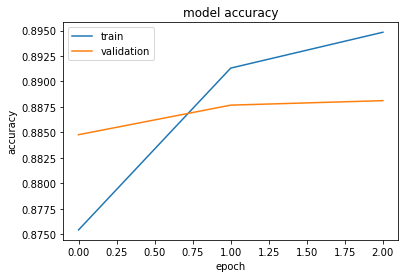

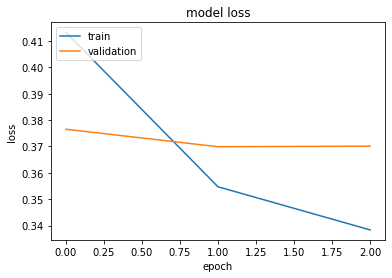

In [108]:
keras.backend.clear_session()

output_length=32 #Embedding
batch_size=256
epochs=3
model_name="model_lstm_fl_zipcomp"

model_lstm_fl_zipcomp=build_model_lstm_zipcode_composition(num_words,num_classes,feature_len,output_length,num_length)

history_lstm_fl_zipcomp=model_lstm_fl_zipcomp.fit([X_train, N_train], y_train, batch_size=batch_size, epochs=epochs,
          validation_data=([X_dev, N_dev], y_dev),verbose=1)

plot_loss_accuracy(history)

In [109]:
#Evaluating the model:

y_pred = model_lstm_fl_zipcomp.predict([X_dev, N_dev], verbose=2)
y_pred=np.argmax(y_pred,axis=1)
target_names = list(df.race.astype('category').cat.categories)
print("Performance on dev set")
print(classification_report(np.argmax(y_dev,axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_dev, axis=1), y_pred))

y_pred = model_lstm_fl_zipcomp.predict([X_test, N_test], verbose=2)
y_pred=np.argmax(y_pred,axis=1)
target_names = list(df.race.astype('category').cat.categories)
print("Performance on test set")
print(classification_report(np.argmax(y_test,axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

model_lstm_fl_zipcomp.save('/Users/nkotova/Documents/CS 230 Deep Learning/project/models/'+model_name+'.tf')

Performance on dev set
              precision    recall  f1-score   support

       asian       0.83      0.79      0.81      3637
    hispanic       0.83      0.78      0.80      5207
    nh_black       0.68      0.41      0.51      2714
    nh_white       0.92      0.96      0.94     38442

    accuracy                           0.90     50000
   macro avg       0.81      0.74      0.77     50000
weighted avg       0.89      0.90      0.89     50000

[[ 2860   121    41   615]
 [   56  4072    54  1025]
 [   45    43  1124  1502]
 [  482   683   434 36843]]
Performance on test set
              precision    recall  f1-score   support

       asian       0.84      0.80      0.82      3769
    hispanic       0.82      0.77      0.80      5066
    nh_black       0.71      0.43      0.54      2656
    nh_white       0.92      0.96      0.94     38509

    accuracy                           0.90     50000
   macro avg       0.82      0.74      0.77     50000
weighted avg       0.90      